> (Última Actualización: 8 de Octubre de 2025)

# Motivación de este colab
<!-- $$\require{amsmath}$$ -->

Recordemos que estamos estudiando **sistemas dinámicos**, con reglas representadas por **ecuaciones diferenciales ordinarias (ODEs)**. Ya vimos como obtener las soluciones numéricamente teniendo las ODEs, y cómo reconstruir las ODEs cuando tengo datos que son una representación subsampleada de las variables. Particularmente, vimos cómo podemos extraer estos datos a partir de videos, con un poco de implementación manual y de ingeniería de atributos.

En esta clase vamos a ver cómo extraer de manera automática una representación topológicamente equivalente al comportamiento dinámico de un sistema. Vamos a **recontruir el espacio de fases** usando métodos lineales de extracción de modos empíricos como SVD, y usando la representación en el espacio latente de redes neuronales con arquitectura de tipo **autoencoders**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Modos Empíricos con SVD

En este Notebook vamos a trabajar con datos experimentales correspondientes a una película del aparato fonador de un ave. En este sistema una membrana oscila debido a la interacción con un flujo de aire (mismo fenómeno que sucede, por ejemplo, en nuestras cuerdas vocales).

Aquí la película en cuestión:

In [ ]:
from IPython.display import Image
Image(url='http://materias.df.uba.ar/sdeiaaamdda2020c2/files/2012/07/membranagif.gif')

Cargamos los datos

In [ ]:
import numpy as np
import imageio
import requests
from io import BytesIO

# Cargar GIF desde la URL
url = 'http://materias.df.uba.ar/sdeiaaamdda2020c2/files/2012/07/membranagif.gif'
response = requests.get(url)
gif = imageio.mimread(BytesIO(response.content))

# Convertir a array (n_frames, height, width, 3)
x = np.array(gif)
print("Forma original:", x.shape)

# Convertir a escala de grises si está en RGB
if x.shape[-1] == 3:
    X = np.mean(x, axis=-1)  # promedio de los canales RGB
else:
    X = x.squeeze()  # por si ya viene en un solo canal

# Normalizar a [0,1]
X = X.astype('float32') / 255.0

# Restar la media
X_medio = np.mean(X)
X = X - X_medio

print("Forma final de X:", X.shape)
print("Valor medio (debería ser ~0):", np.mean(X))


Forma original: (95, 167, 120, 3)
Forma final de X: (95, 167, 120)
Valor medio (debería ser ~0): -9.7713794e-08


Como verán, los archivos constan de 95 frames (imágenes) de la película.

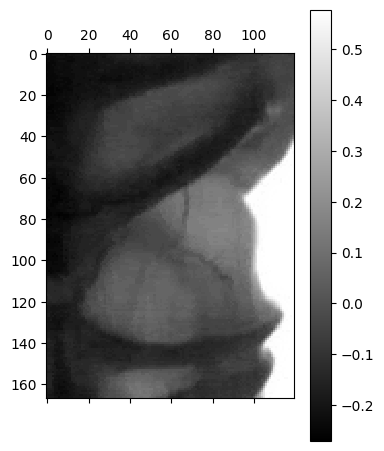

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Graficamos un frame como ejemplo
numero = 55
plt.matshow(X[numero],cmap='gray')
plt.colorbar()
plt.show()

Vamos a "aplastar" el tensor que contiene las 95 imágenes. Es decir que vamos a llevarlo a una forma $(n,m)$ siendo $n = altura \times base$ y siendo $ m = \# \  frames$ .

In [ ]:
# Tomamos las dimensiones de X
dims = np.shape(X)

# Construyo una matriz Y de dimensión n x m con n = altura x base, m = num de frames
Y = np.transpose(np.reshape(X,(dims[0],dims[1]*dims[2])))

print('Shape de la matrix original',np.shape(X))
print('Shape de la matrix aplanada',np.shape(Y))

Shape de la matrix original (95, 167, 120)
Shape de la matrix aplanada (20040, 95)


**Aplicamos SVD**

Usaremos la función de la librería de álgebra lineal de numpy `np.linalg.svd` para realizar la descomposición.

In [ ]:
# SVD para los primeros N frames
N = 95

# # SVD Completo
# Uhat, Shat, Vhat = np.linalg.svd(Y[:,:N], full_matrices=True)

# SVD Económico
Uhat, Shat, Vhat = np.linalg.svd(Y[:,:N], full_matrices=False)

print('Shape de U:', Uhat.shape)
print('Shape de Shat:', Shat.shape)
print('Shape de Vhat:', Vhat.shape)

Shape de U: (20040, 95)
Shape de Shat: (95,)
Shape de Vhat: (95, 95)


**Ejercicio:**
Cambien del SVD completo al SVD económico y vean cómo cambia la forma de las matrices. ¿Qué es lo que está cambiando entre ambos manera de computar la descomposición?

Vamos a graficar el valor de cada uno de los valores singulares y la suma acumulada de los mismos:

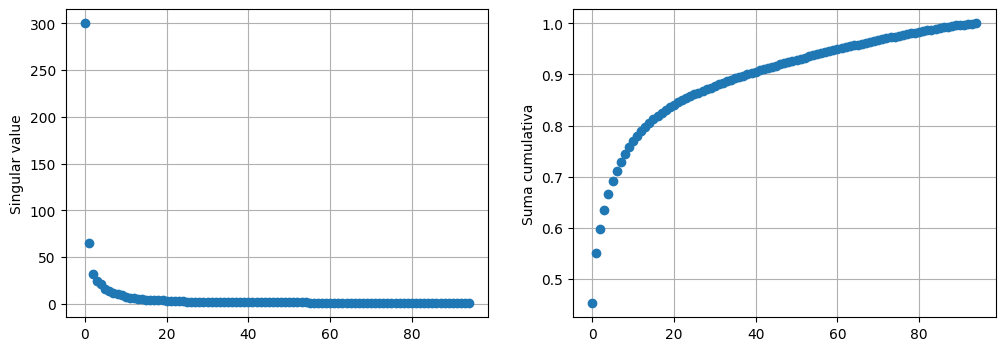

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Shat,'o')
plt.ylabel('Singular value')
plt.grid()
plt.yscale('linear')
plt.subplot(1,2,2)
plt.plot(np.cumsum(Shat)/np.sum(Shat),'o')
plt.ylabel('Suma cumulativa')
plt.grid()

Noten que en la matriz Uhat guardamos la información de los modos espaciales como columnas, mientras que en la matriz Vhat guardamos la evolución temporal de cada uno de estos modos como filas.

Veamos como lucen los primeros 6 modos espaciales.

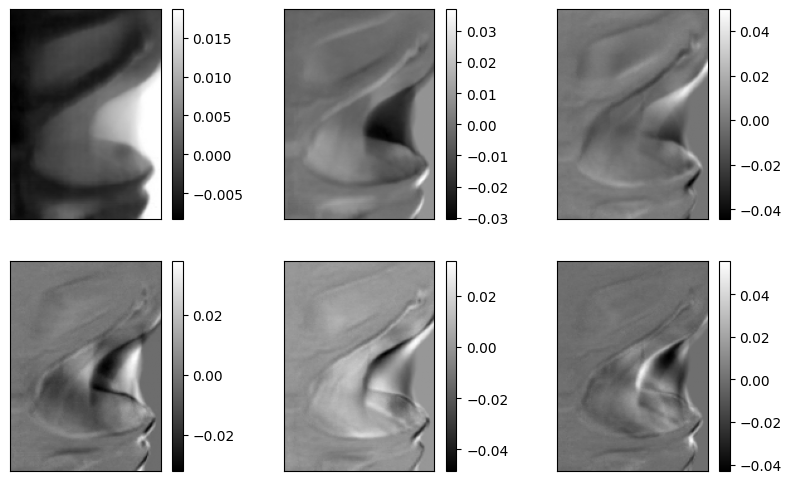

In [ ]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.reshape(Uhat[:,i],(dims[1],dims[2])),cmap='gray',vmin=np.min(Uhat[:,i]),vmax=np.max(Uhat[:,i]))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

**Evolución Temporal de los modos**

Exploremos cómo evolucionan temporalmente los primeros 4 modos empíricos.

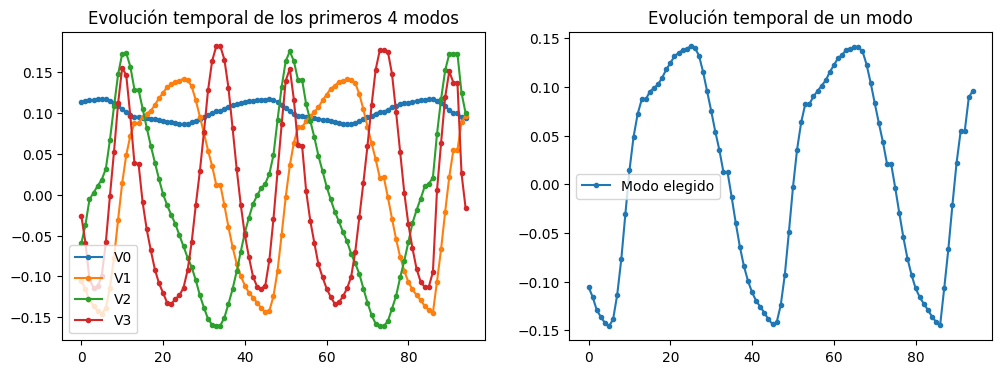

In [ ]:
# PRIMEROS MODOS TEMPORALES

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Vhat[0],'.-',label='V0')
plt.plot(Vhat[1],'.-',label='V1')
plt.plot(Vhat[2],'.-',label='V2')
plt.plot(Vhat[3],'.-',label='V3')
plt.title('Evolución temporal de los primeros 4 modos')
plt.legend()
plt.subplot(1,2,2)

modo = 1
plt.plot(Vhat[modo],'.-',label='Modo elegido')
plt.title('Evolución temporal de un modo')
plt.legend()
plt.show()

Si graficamos la evolución temporal de los primeros 3 modos:

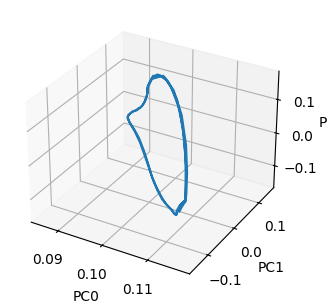

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot(Vhat[0],Vhat[1],Vhat[2])
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.show()

**Discusión:** Observando la imagen de los modos espaciales y su evolución temporal, responda:

*   ¿Podríamos pensar que la evolución de los primeros 3 modos se da dentro de un espacio de fases? ¿Qué tipo de solución sería?
*   Observe el primer modo espacial ¿Parece estar involucrado en la dinámica de la membrana que oscila? ¿A qué podría corresponder?
*   Si tuviese que elegir dos modos que representen la dinámica de oscilación, ¿cuáles eligiríá? Haga un gráfico con únicamente esos modos.

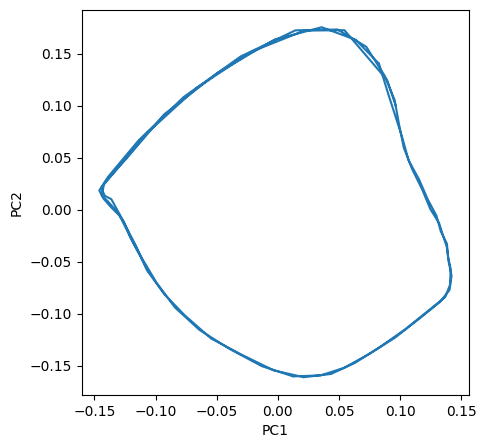

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(Vhat[1],Vhat[2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

**Reconstrucción de la película a partir de los modos truncados**

Por último, vamos a reconstruir la película, pero únicamente utilizando una cantidad truncada de modos.

In [ ]:
# Número de modos que vamos a utilizar
NUM_MODOS = 10

# Defino una lista donde acumularemos las imágenes
lista_proyeccion = []

# Recorro en el tiempo (en nuestro caso son 95 frames)
for j in range(Y.shape[1]):

    # Defino una imagen vacía donde voy a ir sumando la contribución de cada modo
    suma_modos = np.zeros_like(np.reshape(Uhat[:,0],(dims[1],dims[2])))

    # Recorro cada modo
    for i in range(NUM_MODOS):

        # Multiplicamos el modo por su contribución en ese tiempo
        mat = np.dot(Uhat[:,i],Vhat[i,j]*Shat[i])

        # Le damos la forma adecuada y los sumamos a la imagen
        mat = mat.reshape((dims[1],dims[2]))
        suma_modos = suma_modos + mat

    # Por último transformamos la matriz a valores enteros entre 0 y 255
    # (Esto es lo inverso a lo que hicimos al leer los datos)
    suma_modos = suma_modos + X_medio
    suma_modos = suma_modos * 255
    suma_modos = np.clip(suma_modos, 0, 255)
    suma_modos = suma_modos.astype('uint8')
    lista_proyeccion.append(suma_modos)

Guardamos el nuevo gif reconstruido en nuestra carpeta de trabajo:

In [ ]:
import imageio
dir_gif = 'proyeccion.gif'
imageio.mimsave(dir_gif, lista_proyeccion)

Podemos observar como quedó nuestra pelicula realizada unicamente con N modos.

Pelicula generada con  10 modos


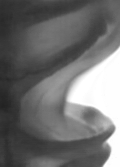

In [ ]:
from IPython.display import Image

print('Pelicula generada con ',NUM_MODOS ,'modos')
Image(open(dir_gif,'rb').read())

**Ejercicio:** Cambien el número de componentes utilizadas y observen cómo cambia la calidad de la animación reconstruida.

# Espacio Latente con Autoencoder

Ahora vamos a trabajar sobre los mismos datos pero usando autoencoders.

In [ ]:
seed_value= 42
# # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# # 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# # 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# tf.random.set_random_seed(seed_value) # Removed old function
tf.random.set_seed(seed_value) # Added new function

**Modos con Autoencoder**

En lugar de utilizar SVD para encontrar modos empíricos de la película, esta vez vamos a utilizar una red neuronal en una arquitectura de **autoencoder** para realizar la reducción dimensional.

A diferencia de las redes que vinimos trabajando hasta ahora, un autoencoder no busca asociar a cada instancia a un valor categórico o numérico, no hay un *target*. Este tipo de algoritmos se denominan de Aprendizaje no supervisado. En este caso, la red se entrena para comprimir la representación de las instancia de entrada de la manera más eficiente posible: intenta reproducir en la salida los mismos valores que hay a su entrada. Es por esto que el número de neuronas en la última capa debe ser igual al número de neuronas que hay a la entrada `numero_pixeles`.

La arquitectura de este tipo de redes suele ser simétrica llamando encoder a la primera parte (todo lo que está antes del cuello de botella, el `latent space`) y decoder a la segunda parte.

In [ ]:
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation # Updated import

numero_pixeles = Y.shape[1]
NUM_MODOS = 3

# building a linear stack of layers with the sequential model
model = Sequential()

# Encoder: comprimimos la representación achicando el número de neuronas
model.add(Dense(64, input_shape=(numero_pixeles,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(NUM_MODOS, activation='linear')) # Latent Space: Punto máximo de la compresión

# Decoder: llevamos nuevamente al mismo tamaño que la entrada
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(units=numero_pixeles, activation='linear'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 95)             │         6,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,698 (69.13 KB)

 Trainable params: 17,698 (69.13 KB)

 Non-trainable params: 0 (0.00 B)

Como dijimos, nuestro objetivo será reproducir la entrada, por lo tanto a la hora de entrenar el modelo debemos pasarle como salida el mismo dataset que a la entrada:

In [ ]:
# training the model and saving metrics in history
history = model.fit(Y, Y,
          batch_size=16,
          epochs=500,
          validation_split=0.25,
          verbose=1)

Epoch 1/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0491 - val_loss: 0.0015 - val_mean_absolute_error: 0.0240
Epoch 2/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0204 - val_loss: 0.0015 - val_mean_absolute_error: 0.0222
Epoch 3/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 9.3196e-04 - mean_absolute_error: 0.0182 - val_loss: 0.0014 - val_mean_absolute_error: 0.0204
Epoch 4/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7.2430e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0014 - val_mean_absolute_error: 0.0203
Epoch 5/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.5818e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0014 - val_mean_absolute_error: 0.0199
Epoch 6/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.1375e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0013 - val_mean_absolute_error: 0.0197
Epoch 7/500
940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.8801e-04 - mean

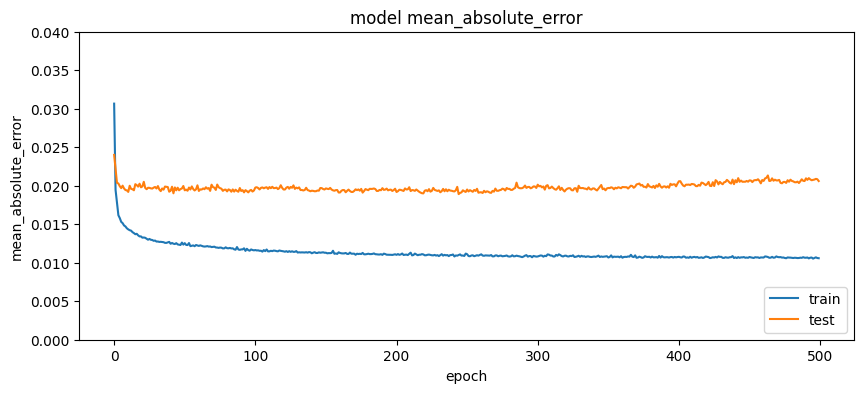

In [ ]:
fig = plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.ylim(0,0.04)
plt.show()

In [ ]:
# # save model
# model.save('model_autoencoder.h5')
# # load model
# # from keras.models import load_model
# model = keras.models.load_model('model_autoencoder.h5')

Para poder acceder al `Latent Space` (la capa con la menor cantidad de neuronas), vamos a definir una función:

In [ ]:
from keras import backend as K
import tensorflow as tf # Import tensorflow
get_latent_layer_output = tf.keras.Model(model.layers[0].input, model.layers[3].output) # Replace K.function with tf.keras.Model

Ahora sí, veamos cómo queda representado el dataset en el `Latent Space`.

In [ ]:
layer_output = get_latent_layer_output(Y)
print(layer_output.shape)

(20040, 3)


Noten que ahora tenemos una cantidad `NUM_MODOS` por cada instancia (por cada frame).

**Evolución Temporal de los modos**

Exploremos cómo evolucionan temporalmente los primeros modos empíricos.

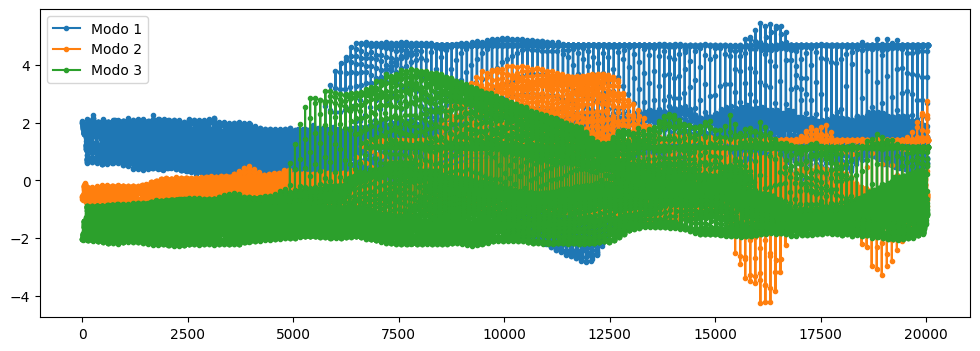

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,1,1)
plt.plot(layer_output[:,0],'.-',label='Modo 1')
plt.plot(layer_output[:,1],'.-',label='Modo 2')
plt.plot(layer_output[:,2],'.-',label='Modo 3')
plt.legend()
plt.show()

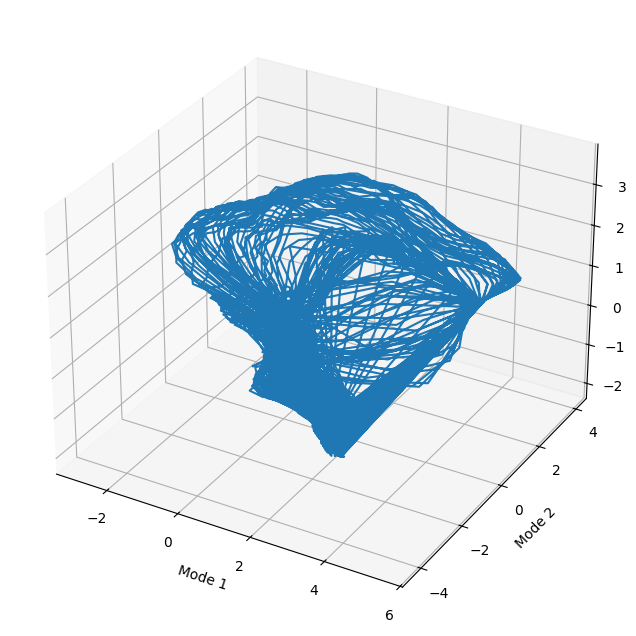

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax = fig.gca(projection='3d') # Remove the incorrect line
ax.plot(layer_output[:,0],layer_output[:,1],layer_output[:,2])
ax.set_xlabel('Mode 1')
ax.set_ylabel('Mode 2')
ax.set_zlabel('Mode 3')
plt.show()

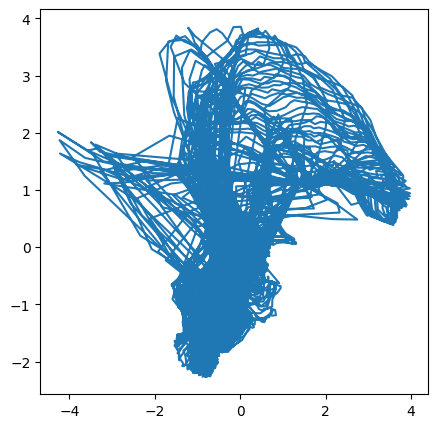

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(layer_output[:,1],layer_output[:,2])
plt.show()

**Reconstrucción de la película**

Por último, vamos a reconstruir la película, pero utilizando la salida de la red. Esto sería equivalente a utilizar los modos encontrados, ya que los valores que vemos a la salida de la red están determinados por los valores en las neuronas del `Latent Space`.

In [ ]:
# Defino una lista donde acumularemos las imágenes
lista_proyeccion = []

# Predict on the entire dataset to get the reconstructed flattened images
Y_reconstructed = model.predict(Y)

# Recorro en el tiempo (en nuestro caso son 95 frames)
for j in range(Y_reconstructed.shape[0]):

    # Reshape the reconstructed flattened image back to the original dimensions
    suma_modos = Y_reconstructed[j].reshape((dims[1], dims[2]))

    # Por último Transformamos la matriz a valores enteros entre 0 y 255
    # (Esto es lo inverso a lo que hicimos al leer los datos)
    suma_modos = suma_modos + X_medio
    suma_modos = suma_modos * 255
    suma_modos = np.clip(suma_modos, 0, 255)
    suma_modos = suma_modos.astype('uint8')
    lista_proyeccion.append(suma_modos)

627/627 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


ValueError: cannot reshape array of size 95 into shape (167,120)

Guardamos el nuevo gif reconstruido en nuestra carpeta de trabajo:

In [ ]:
import imageio
dir_gif = 'proyeccion_autoencoder.gif'
imageio.mimsave(dir_gif, lista_proyeccion)

Podemos observar como quedó nuestra película realizada únicamente con N modos.

In [ ]:
from IPython.display import Image

print('Pelicula generada con ',NUM_MODOS ,'modos')
Image(open(dir_gif,'rb').read())

**Ejercicio:** Compare el desempeño de la descomposición modal realizada con el autoencoder contra el mecanismo de SVD para distintos valores de N (número de modos). Para esto, utilice como métrica el Mean square error (diferencia entre imagen original y reconstruida).

In [ ]:
Y_proy = np.transpose(np.reshape(np.array(lista_proyeccion),(dims[0],dims[1]*dims[2]))).T

In [ ]:
# from keras import metrics
# metrics.mean_squared_error(Y, Y_proy)
# np.mean(np.square(Y - Y_proy), axis=-1)
np.mean((Y_proy - Y)**2, axis=1)

## Extra: Interpretación de los modos

En este esquema de trabajo es dificil interpretar a qué corresponde cada modo. De hecho, al tratarse de modos no lineales, mirando la activación del modo 1 y del modo 2 por separado, no es posible inferir cómo será la interacción de ambos modos activos al mismo tiempo. Más aún, una activación de un único modo con intensidad 2, no necesariamente genera una imagen que sea equivalente 2 veces la imgen generada por eso modo con intensidad 1.

Sin embargo, podemos hacer un intento y graficar cómo se verían las imágenes para cada modo activado por separado.

Para esto será necesario definir el modelo de otra forma, ya que luego vamos a querer definir "a mano" el valor de activación en la capa correspondiente al `latent space`.

**Importante:** No es necesario que comprendan el código a continuación.

In [ ]:
from keras.layers import Dense, Activation, Input
from keras.models import Model

numero_pixeles = Y.shape[1]
NUM_MODOS = 3


# Definimos las capas que del encoder y cómo se conectan
input_img= Input(shape=(numero_pixeles,))
encoded = Dense(units=64, activation='relu')(input_img)
encoded = Dense(units=32, activation='relu')(encoded)
encoded = Dense(units=16, activation='relu')(encoded)

# Usamos neuronas que pueden tomar valores negativos para la hidden layer.
encoded = Dense(units=NUM_MODOS, activation='linear')(encoded)

# Definimos las capas del decoder
decoder_1 = Dense(units=16, activation='relu')
decoder_2 = Dense(units=32, activation='relu')
decoder_3 = Dense(units=64, activation='relu')
decoder_4 = Dense(units=numero_pixeles, activation='linear')

# Definimos cómo se conectan las capas del decoder en el autoencoder
decoder_1_output = decoder_1(encoded)
decoder_2_output = decoder_2(decoder_1_output)
decoder_3_output = decoder_3(decoder_2_output)
decoder_4_output = decoder_4(decoder_3_output)

# Preparamos unas capas para el modelo que nos lleve del
# valor de las 3 neuronas del latent space a una imagen (el decoder)
input_modos = Input(shape=(NUM_MODOS,))
modos_1_act = decoder_1(input_modos)
modos_2_act = decoder_2(modos_1_act)
modos_3_act = decoder_3(modos_2_act)
modos_4_act = decoder_4(modos_3_act)


# Definimos el modelo autoencoder y el encoder
autoencoder = Model(input_img, decoder_4_output)
encoder = Model(input_img, encoded)

# Definimos un modelo para inspeccionar los modos
modos_activacion = Model(input_modos, modos_4_act)

autoencoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 95)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 95)             │         6,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,698 (69.13 KB)

 Trainable params: 17,698 (69.13 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos y entrenamos el modelo.

In [ ]:
autoencoder.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')
# training the model and saving metrics in history
history = autoencoder.fit(Y, Y,
          batch_size=16,
          epochs=500,
          validation_split=0.25,
          verbose=1)

Epoch 1/500


KeyboardInterrupt: 

Graficamos la activación de los modos para las imágenes del dataset en función del tiempo.

In [ ]:
# Usamos un modelo que nos lleva de los datos a la capa intermedia (latent space)
layer_output = encoder.predict(Y)

plt.figure(figsize=(12,5))
plt.subplot(1,1,1)
plt.plot(layer_output[:,0],'.-',label='Modo 1')
plt.plot(layer_output[:,1],'.-',label='Modo 2')
plt.plot(layer_output[:,2],'.-',label='Modo 3')
plt.legend()Interpretación

In [ ]:
encoder.summary()

Observe el valor de activación de cada una de las 3 neuronas (eje y) en la serie temporal graficada en la celda anterior. Tome estos valores como una referencia de que puede considerar como valor de activación para cada uno de los modos.

Por último, vamos a imponerle valores a la capa intermedia del modelo y ver cuál es la imagen a la salida.

Recuerden algo importante: en este esquema no hay una jerarquía de importancia entre los modos.

In [ ]:
# Elegimos el valor de las neuronas en la capa intermedia
# Y guardamos la salida del autoencoder para cada uno de los modos
modo_1 = modos_activacion.predict(np.asarray([0,0,10]).reshape(1,3))
modo_2 = modos_activacion.predict(np.asarray([0,10,0]).reshape(1,3))
modo_3 = modos_activacion.predict(np.asarray([10,0,0]).reshape(1,3))


# Graficamos
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(np.reshape(modo_1,(dims[1],dims[2])),cmap='gray',vmin=np.min(modo_1),vmax=np.max(modo_1))
plt.subplot(1,3,2)
plt.imshow(np.reshape(modo_2,(dims[1],dims[2])),cmap='gray',vmin=np.min(modo_2),vmax=np.max(modo_2))
plt.subplot(1,3,3)
plt.imshow(np.reshape(modo_3,(dims[1],dims[2])),cmap='gray',vmin=np.min(modo_3),vmax=np.max(modo_3))

plt.show()

Como verán, es muy dificil interpretar los modos. Esto evidencia un trade-off bastante universal: una reducción de dimensionalidad más efectiva (no lineal) conlleva una pérdida de intepretabilidad de los modos encontrados.

# Ejercicio 1

Ahora vamos a aplicar estas estrategias para extraer automáticamente la dinámica desde un video a partir del oscilador amortiguado que vimos en las clases de *ajuste de datos* y de *reconstrucción de ODEs*. De esta manera vamos a poder reconstruir el espacio de fases a partir de encontrar trayectorias en el espacio latente del autoencoder, cuya dinámica es topológicamente equivalente al espacio de fases original.

In [ ]:
# # # COMPLETAR

# Ejercicio 2

Como vieron, esto es una herramienta muy poderosa para encontrar oscilaciones a partir de videos muy generales. Busquen de probar con algún video que pueda serles de interés. Por ejemplo, en el video de este link "https://www.youtube.com/watch?v=ASqqp0a8LqI", al final, a partir del minuto 3:50, tienen una oscilación muy peculiar. Pero busquen posibles videos que puedan aprovechar con estas herramientas.

In [ ]:
# # # COMPLETAR